# Установка пакетов, догрузка необходимых файлов и функций

In [ ]:
!pip install PyPro
!pip install propy3
!pip install modlamp
!pip install brewer2mpl

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from propy import PyPro
from modlamp.database import query_database
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from modlamp.sequences import Helices

In [ ]:
#Чтение файла и фильтрация последовательностей
def read_and_filter(path, filenames):
    peptides = {}
    peptides_length = []
    for name in filenames:
        filename = path + filenames[name]
        seq = ''
        with open(filename, 'r') as file:
            for line in file:
                if line[0] != '>':
                    flag = True
                    seq = replace_all(line.strip(), label)
                if seq not in peptides and len(seq) > 4 and not set(seq) - set(amino_acids):
                    peptides[seq] = [name, len(seq)]
                    peptides_length.append(len(seq))
    return peptides, peptides_length

#Удаление меток
def replace_all(text, to_replase):
    for key in to_replase:
        text = text.replace(key, to_replase[key])
    return text

#Источник последовательностей
def web_resource(filenames, peptides):
    resource = filenames.keys()
    result = dict.fromkeys(resource, 0)
    for key in peptides:
        result[peptides[key][0]] += 1
    print(result)

#Запись в файл
def writing_to_file(filename, data):
    with open(filename, 'w') as file:
        for key in data:
            file.write(key + '\n')

#Словарь для записи дескрипторов
def create_a_dictionary(feature, parameter):
    if len(feature) == 0:
        for key in parameter:
            feature[key] = [parameter[key]]
    else:
        if parameter != 0:
            for key in parameter:
                feature[key].append(parameter[key])
        else:
            for key in feature:
                feature[key].append(0)
    return feature

#Удаление высокоскоррелированных дескрипторов
def corr_descriptors(data, corr_val):
    corr_matrix = data.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)
    drops = sorted(set(drop_cols))[::-1]
    new_data = data.copy()
    for i in drops:
        del new_data[data.columns[i]]
    return new_data

#Функция для построения тепловой карты
def create_a_corr_table(df_feature, flag):
    corr_table = round(df_feature.corr(), 2)
    plt.figure(figsize=(120,60), dpi= 100)
    sns.heatmap(abs(corr_table), xticklabels=corr_table.columns, yticklabels=corr_table.columns, alpha = 0.75,
                cmap=sns.diverging_palette(0, 125, as_cmap=True), annot=flag, center = 0, square=True)
    plt.xticks(rotation=90)
    plt.show()

#Форматирование изображений
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [ ]:
CPP_pos_folder_path = 'Algorithm/1. Sample creation/CPPs/'
CPP_neg_folder_path = 'Algorithm/1. Sample creation/nonCPPs/'
Total_sample_path = 'Algorithm/1. Sample creation/Total/'

CPP_pos_names = {'CPPsite2.0' : 'natural_pep_CPP20.txt',
                 'C2Pred' : 'all_cpps.txt', 'SkipCPP' : 'first462_positive_SkipCPP-Pred.txt', 
                 'MLCPP' : 'GT-positive.txt', 
                 'CellPPD_dataset1' : 'positive_peptides_cellppd_dataset1.txt'}
CPP_neg_names = {'C2Pred' : 'all_noncpps.txt', 'MLCPP' : 'GT-negative.txt',
                 'SkipCPP' : 'last462_negative_SkipCPP-Pred.txt', 
                 'CellPPD_dataset1' : 'negative_peptides_dataset1.txt', 
                 'CellPPD_dataset2' : 'negative_peptides_dataset2.txt'}

amino_acids = ['A','R','N','D','C','H','G','Q','E','I','L','K','M','P','S','Y','T','W','F','V']
label = {'Biotin(O)': '', 'CREKA': '', 'Ac': '', 'mPEG-PLA': '', 'mPEGPLA': '', 
         'PEG-PLA': '', 'PEGPLA': '', 'Ahx': '', 'ahx': '', 'ISF': '', 'mPEGPLA': '',
         'R8': 'RRRRRRRR', 'S5': 'SSSSS', '-':''}

# Чтение и обработка последовательностей

Объединение файлов из разных баз данных, удаление дубликатов и пептидов с нетипичными ак

## Проникающие пептиды

In [ ]:
CPP_pos, CPP_pos_length = read_and_filter(CPP_pos_folder_path, CPP_pos_names)
web_resource(CPP_pos_names, CPP_pos)
print('Минимальная длина', min(CPP_pos_length), '\nМаксимальная длина', max(CPP_pos_length))

{'CPPsite2.0': 1168, 'C2Pred': 16, 'SkipCPP': 0, 'MLCPP': 1, 'CellPPD_dataset1': 1}
Минимальная длина 5 
Максимальная длина 61


In [ ]:
file_name = CPP_pos_folder_path + 'CPPs_positive.txt'
writing_to_file(file_name, CPP_pos)

## Непроникающие пептиды

In [ ]:
CPP_neg, CPP_neg_length = read_and_filter(CPP_neg_folder_path, CPP_neg_names)

Непроникающие пептиды были пропущены через CD-HIT с параметрами Sequence identity cut-off = 0,45 и length of sequence to skip = 5 (остальные по умолчанию), чтобы избавиться от гомологичных последовательностей. 

В результате была получена 1351 последовательность в файле CD_HIT_nonCPP.fasta

In [ ]:
CD_HIT_nonCPP = []
CD_HIT_name = CPP_neg_folder_path + 'CD_HIT_nonCPP.fasta'
with open(CD_HIT_name, 'r') as file:
    for line in file:
        l = line.strip()
        if l != '' and l[0] != '>':
            CD_HIT_nonCPP.append(l)

#Удаление лишнего
double_dict = CPP_neg.copy()
for key in double_dict.keys():
    if key not in CD_HIT_nonCPP or key in CPP_pos:
        del CPP_neg[key]

#Длины пептидов
CPP_neg_length = list()
for key in CPP_neg:
    CPP_neg_length.append(CPP_neg[key][1])

file_name = CPP_neg_folder_path + 'CPPs_negative.txt'
writing_to_file(file_name, CPP_neg)

In [ ]:
web_resource(CPP_neg_names, CPP_neg)
print('Минимальная длина', min(CPP_neg_length), '\nМаксимальная длина', max(CPP_neg_length))

{'C2Pred': 189, 'MLCPP': 431, 'SkipCPP': 349, 'CellPPD_dataset1': 106, 'CellPPD_dataset2': 137}
Минимальная длина 5 
Максимальная длина 58


## Распределение длин

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


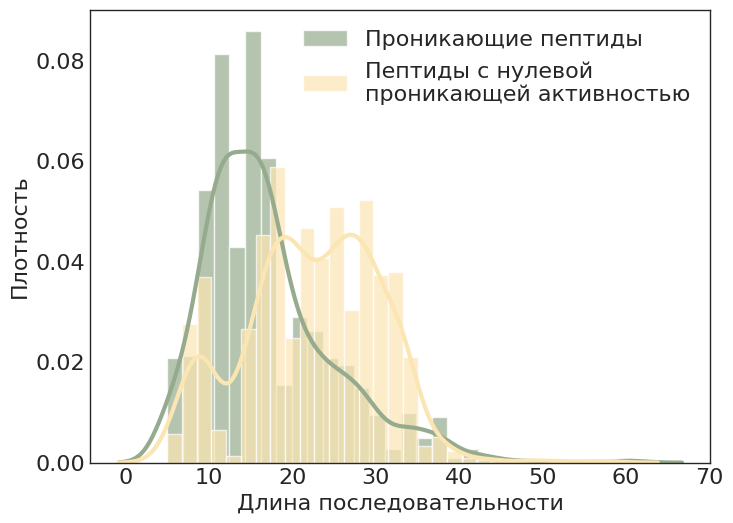

In [ ]:
plt.figure(figsize=(8,6), dpi= 100)
sns.distplot(CPP_pos_length, color='#96ab8d', label="Проникающие пептиды", 
             hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, bins = 30)
sns.distplot(CPP_neg_length, color='#fbe5b3', label="Пептиды с нулевой"+"\n"+"проникающей активностью", 
             hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, bins = 30)

plt.ylabel("Плотность")
plt.xlabel("Длина последовательности")
plt.legend()
plt.show()

# Формирование обучающей выборки

In [ ]:
Sample = {'CPP': [True]*len(CPP_pos) + [False]*len(CPP_neg),
          'Sequence': list(CPP_pos.keys()) + list(CPP_neg.keys())}
df_SAMPLE = pd.DataFrame(Sample)
#df_SAMPLE.to_csv(Total_sample_path + 'df_SAMPLE_no_desc.csv', index = False)
#df_SAMPLE = pd.read_csv(Total_sample_path + 'df_SAMPLE_no_desc.csv')

## Первичные Дескрипторы

### APAAC

Amphiphilic pseudo amino acid composition descriptors(depend on the choice of lamda, the default is 50)

In [ ]:
APAAC = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        apaac = DesObject.GetAPAAC()
    except ZeroDivisionError:
        apaac = 0
    APAAC = create_a_dictionary(APAAC, apaac)

In [ ]:
APAAC_with_A = {}

for key in APAAC.keys():
    old_key = key
    if key[0] != 'A':
        key = 'A' + key
    APAAC_with_A[key] = APAAC[old_key]
APAAC = pd.DataFrame(APAAC_with_A)

### PAAC
Pseudo amino acid composition descriptors (depend on the choice of lamda, the default is 50)

In [ ]:
PAAC = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        paac = DesObject.GetPAAC()
    except ZeroDivisionError:
        paac = 0
    PAAC = create_a_dictionary(PAAC, paac)
PAAC = pd.DataFrame(PAAC)

### QSO
Quasi-sequence order descriptors (depend on the choice of maxlag, the default is 100)

In [ ]:
QSO = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        qso = DesObject.GetQSO()
    except ZeroDivisionError:
        qso = 0
    QSO = create_a_dictionary(QSO, qso)
QSO = pd.DataFrame(QSO)

### SOCN
Sequence order coupling numbers (depend on the choice of maxlag, the default is 60)

In [ ]:
SOCN = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        socn = DesObject.GetSOCN()
    except ZeroDivisionError:
        socn = 0
    SOCN = create_a_dictionary(SOCN, socn)
SOCN = pd.DataFrame(SOCN)

### CTD
Composition, Transition, Distribution descriptors (CTD) (21+21+105=147)

In [ ]:
CTD = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        ctd = DesObject.GetCTD()
    except ZeroDivisionError:
        ctd = 0
    CTD = create_a_dictionary(CTD, ctd)
CTD = pd.DataFrame(CTD)

### Gearyauto
Geary autocorrelation descriptors(depend on the given properties, the default is 240)

In [ ]:
GEAR = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        gear = DesObject.GetGearyAuto()
    except ZeroDivisionError:
        gear = 0
    GEAR = create_a_dictionary(GEAR, gear)
GEAR = pd.DataFrame(GEAR)

### Moranauto
Moran autocorrelation descriptors(depend on the given properties, the default is 240)

In [ ]:
MORAN = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        moran = DesObject.GetMoranAuto()
    except ZeroDivisionError:
        moran = 0
    MORAN = create_a_dictionary(MORAN, moran)
MORAN = pd.DataFrame(MORAN)

### MBauto
Normalized Moreau-Broto autocorrelation descriptors (depend on the given properties, the default is 240)

In [ ]:
MB = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        mb = DesObject.GetMoreauBrotoAuto()
    except ZeroDivisionError:
        mb = 0
    MB = create_a_dictionary(MB, mb)
MB = pd.DataFrame(MB)

### modlAMP

In [ ]:
AMP = GlobalDescriptor(list(df_SAMPLE['Sequence']))

AMP.charge_density(ph=6, amide=True)
ch_density = pd.DataFrame({"ChargeDensity": AMP.descriptor.flatten().tolist()})

AMP.isoelectric_point()
i_point = pd.DataFrame({"pI": AMP.descriptor.flatten().tolist()})

AMP.instability_index()
i_index = pd.DataFrame({"InstabilityInd": AMP.descriptor.flatten().tolist()})

AMP.aromaticity()
aromatic = pd.DataFrame({"Aromaticity": AMP.descriptor.flatten().tolist()})

AMP.aliphatic_index()
a_index = pd.DataFrame({"AliphaticInd": AMP.descriptor.flatten().tolist()})

AMP.boman_index()
b_index = pd.DataFrame({"BomanInd": AMP.descriptor.flatten().tolist()})

AMP.hydrophobic_ratio()
h_ratio = pd.DataFrame({"HydrophRatio": AMP.descriptor.flatten().tolist()})

modlamp_descriptors = [ch_density, i_point, i_index, aromatic, a_index, b_index, h_ratio]
modl_AMP = modlamp_descriptors[0]
for df in modlamp_descriptors[1:]:
    modl_AMP = pd.concat([modl_AMP, df], axis = 1)

## Построение корреляционных таблиц


In [ ]:
all_descriptors = [APAAC, PAAC, QSO, SOCN, CTD, GEAR, MORAN, MB, modl_AMP]
all_descriptors_names = ['APAAC', 'PAAC', 'QSO', 'SOCN', 'CTD', 'GEAR', 'MORAN', 'MB', 'modl_AMP']

Тепловая карта для группы дескрипторов APAAC


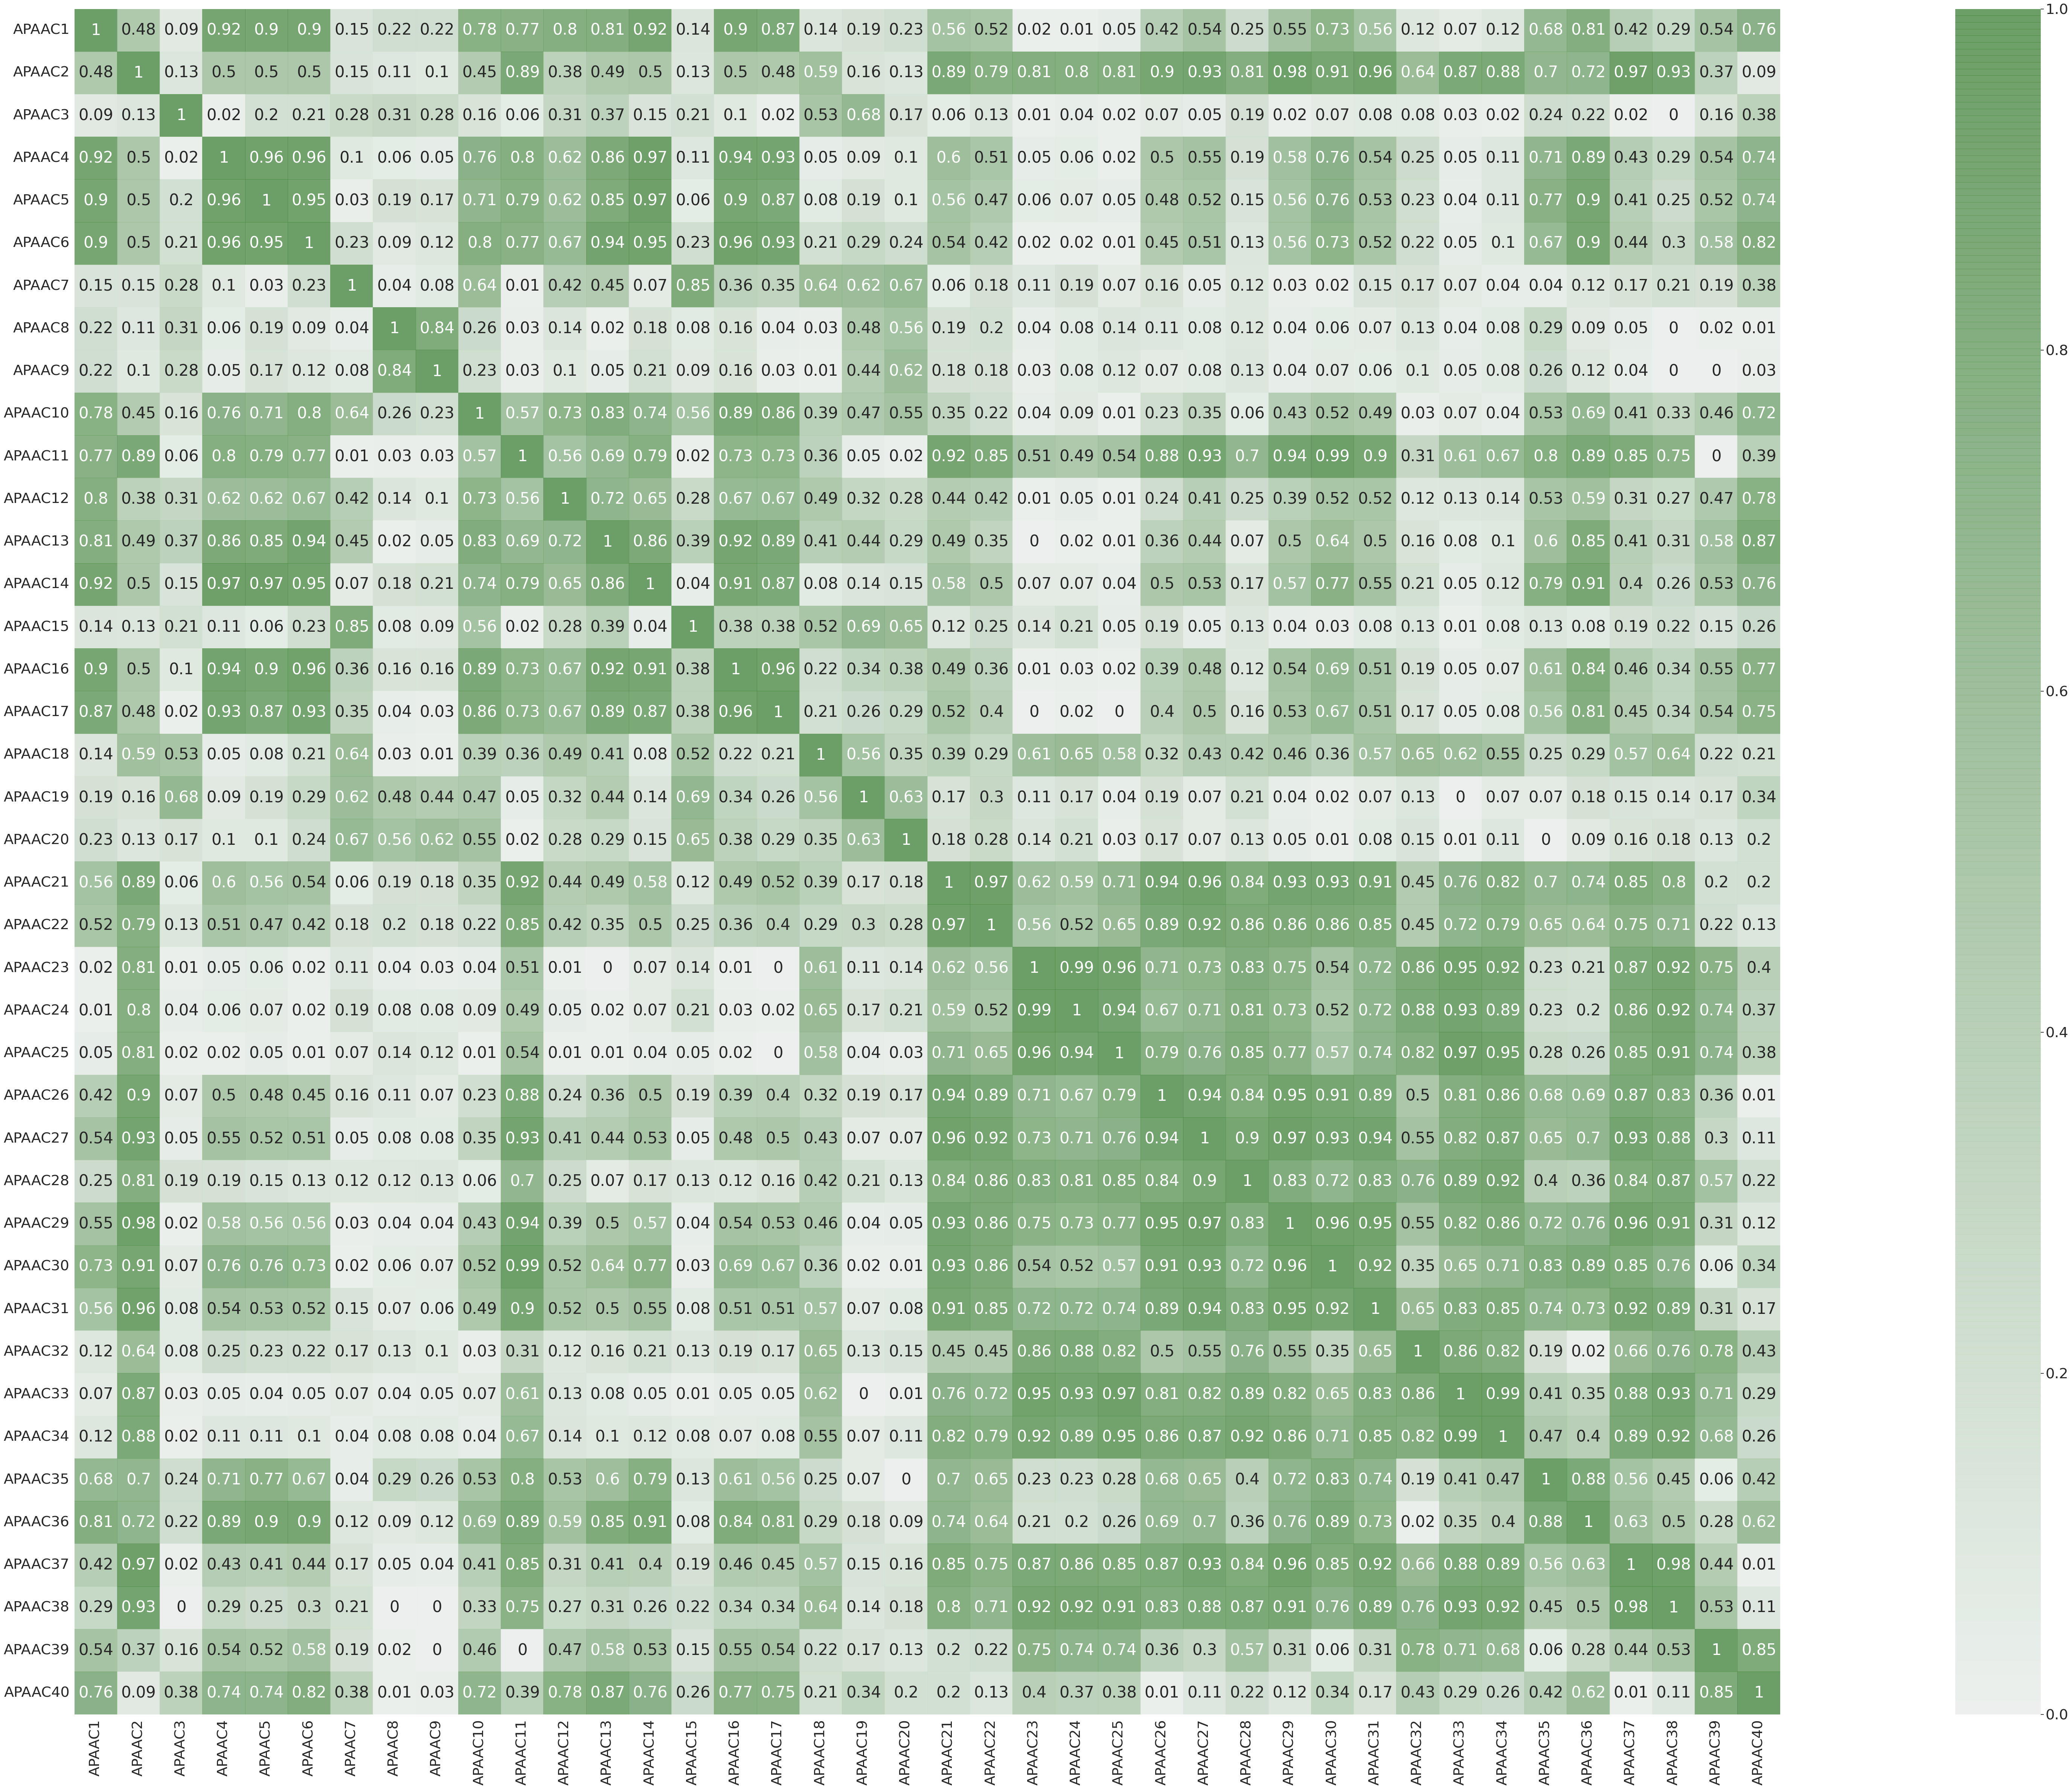

Тепловая карта для группы дескрипторов PAAC


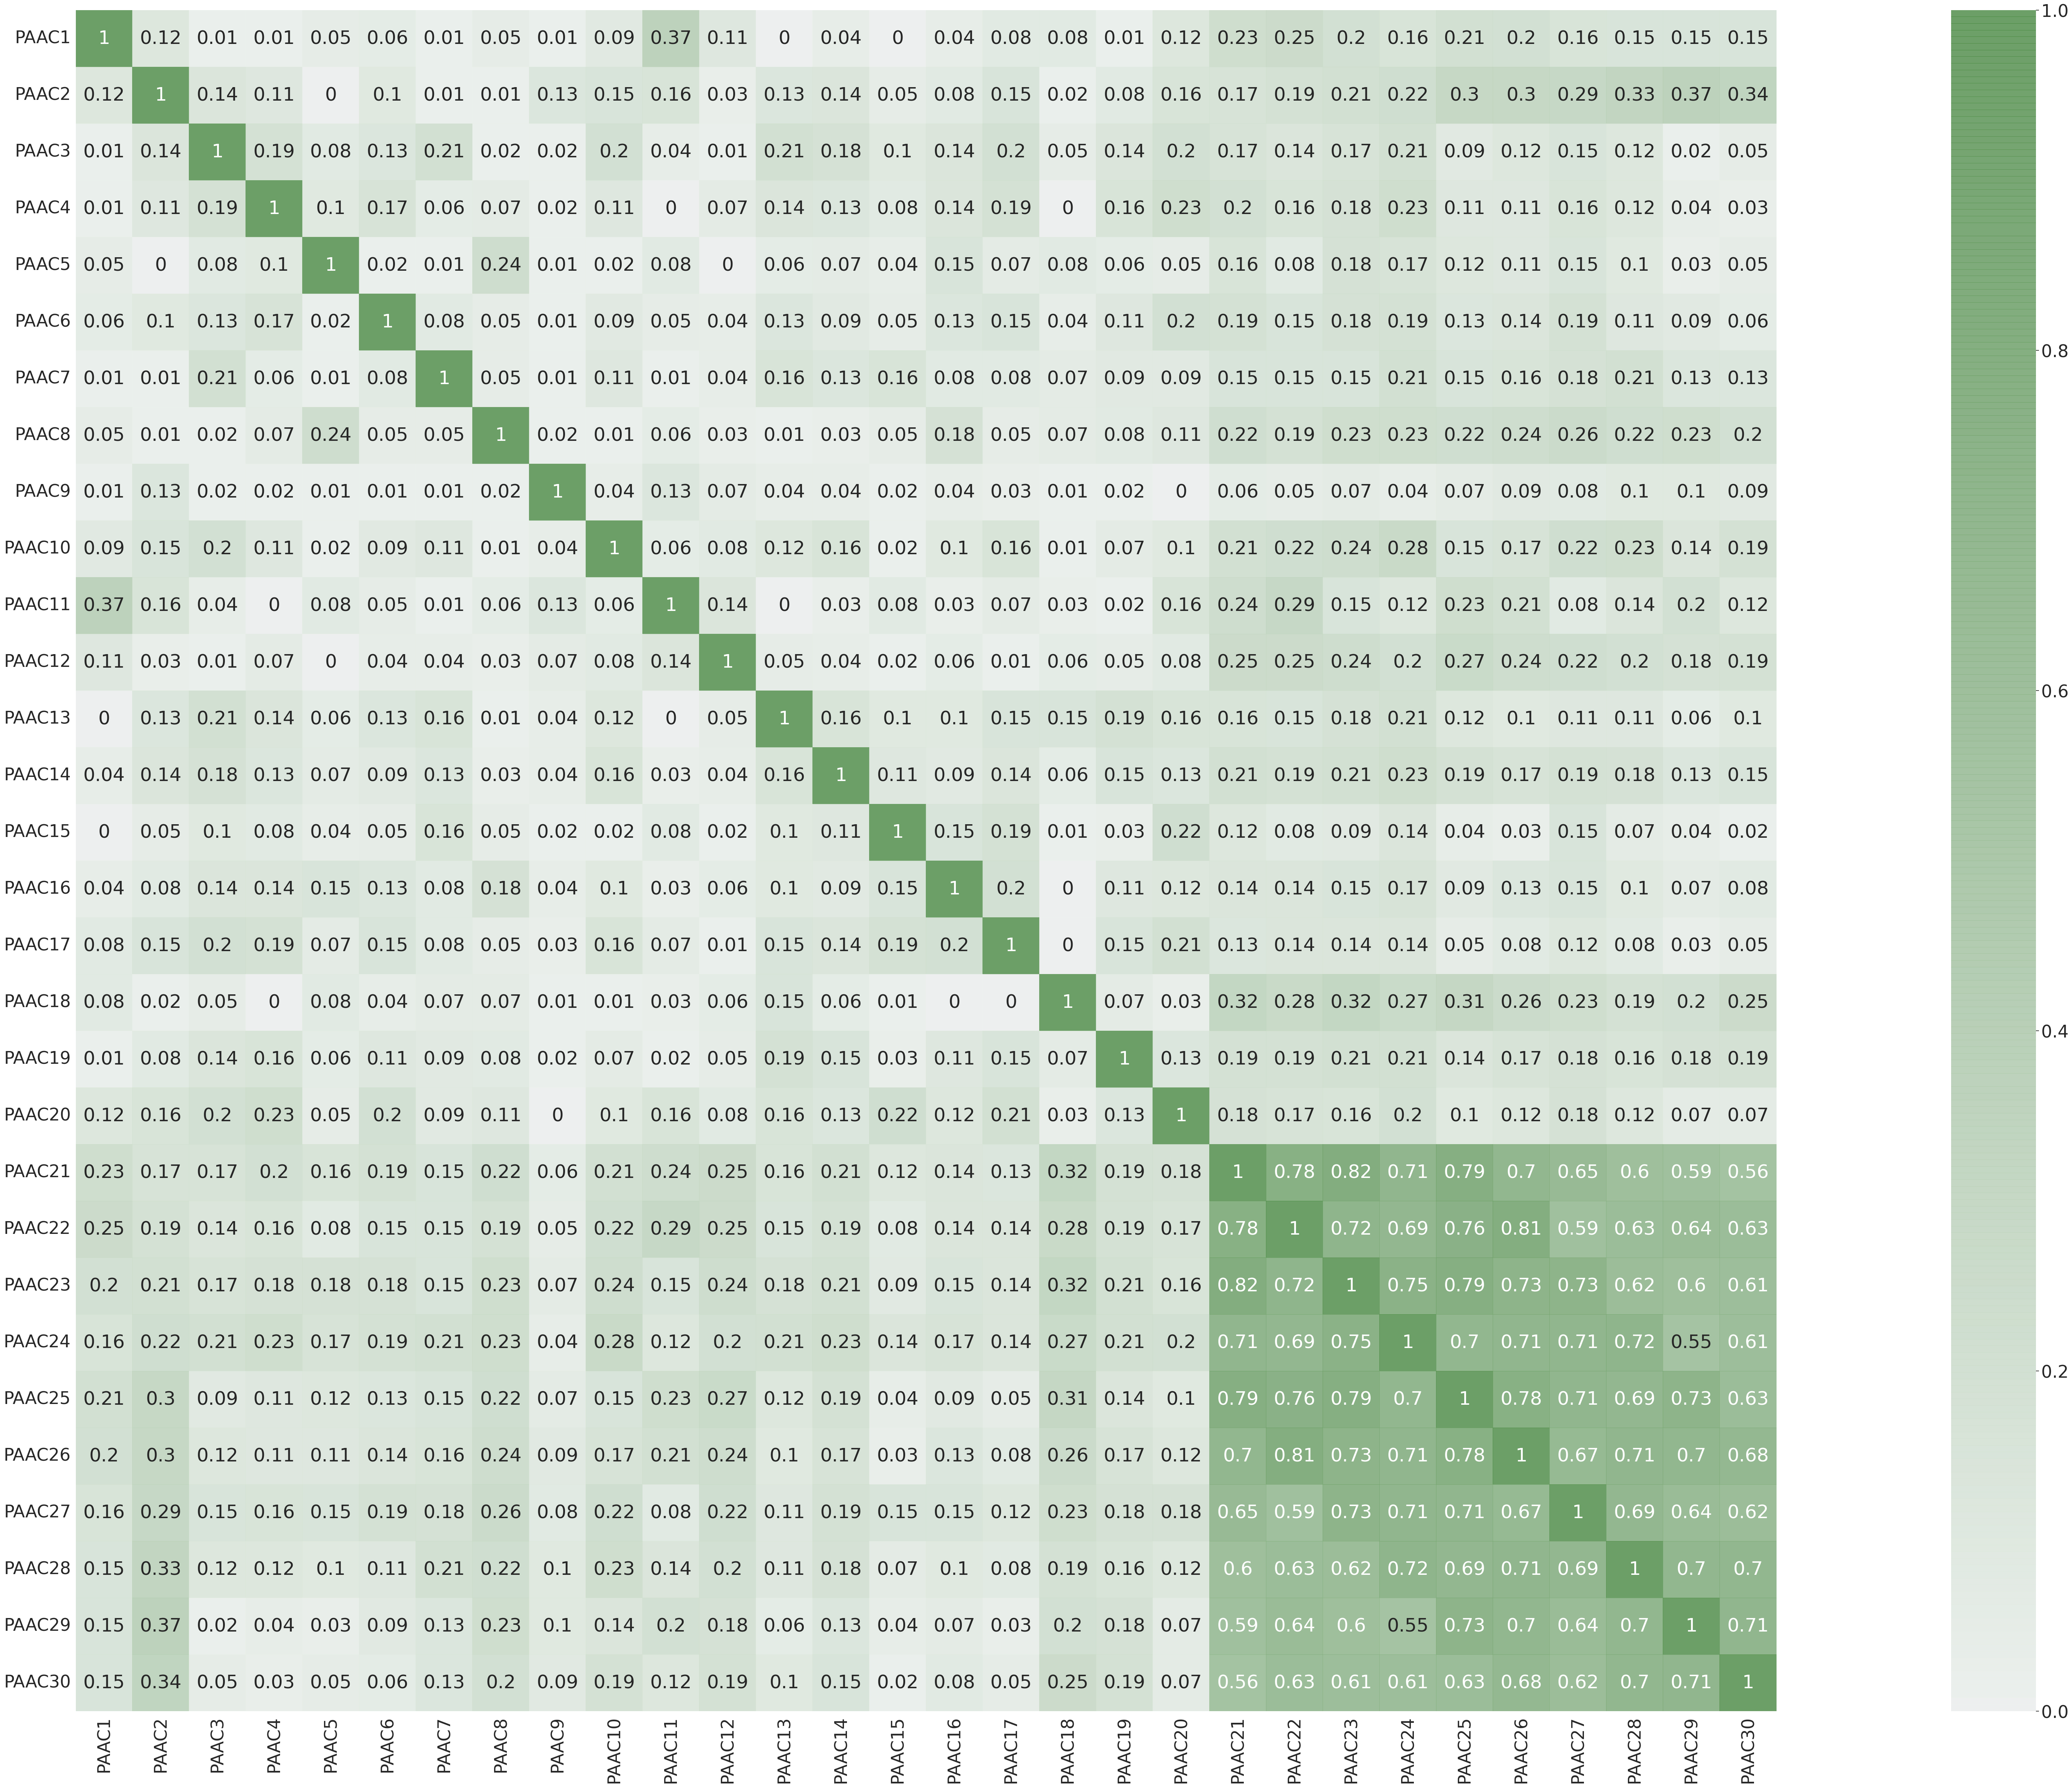

Тепловая карта для группы дескрипторов modl_AMP


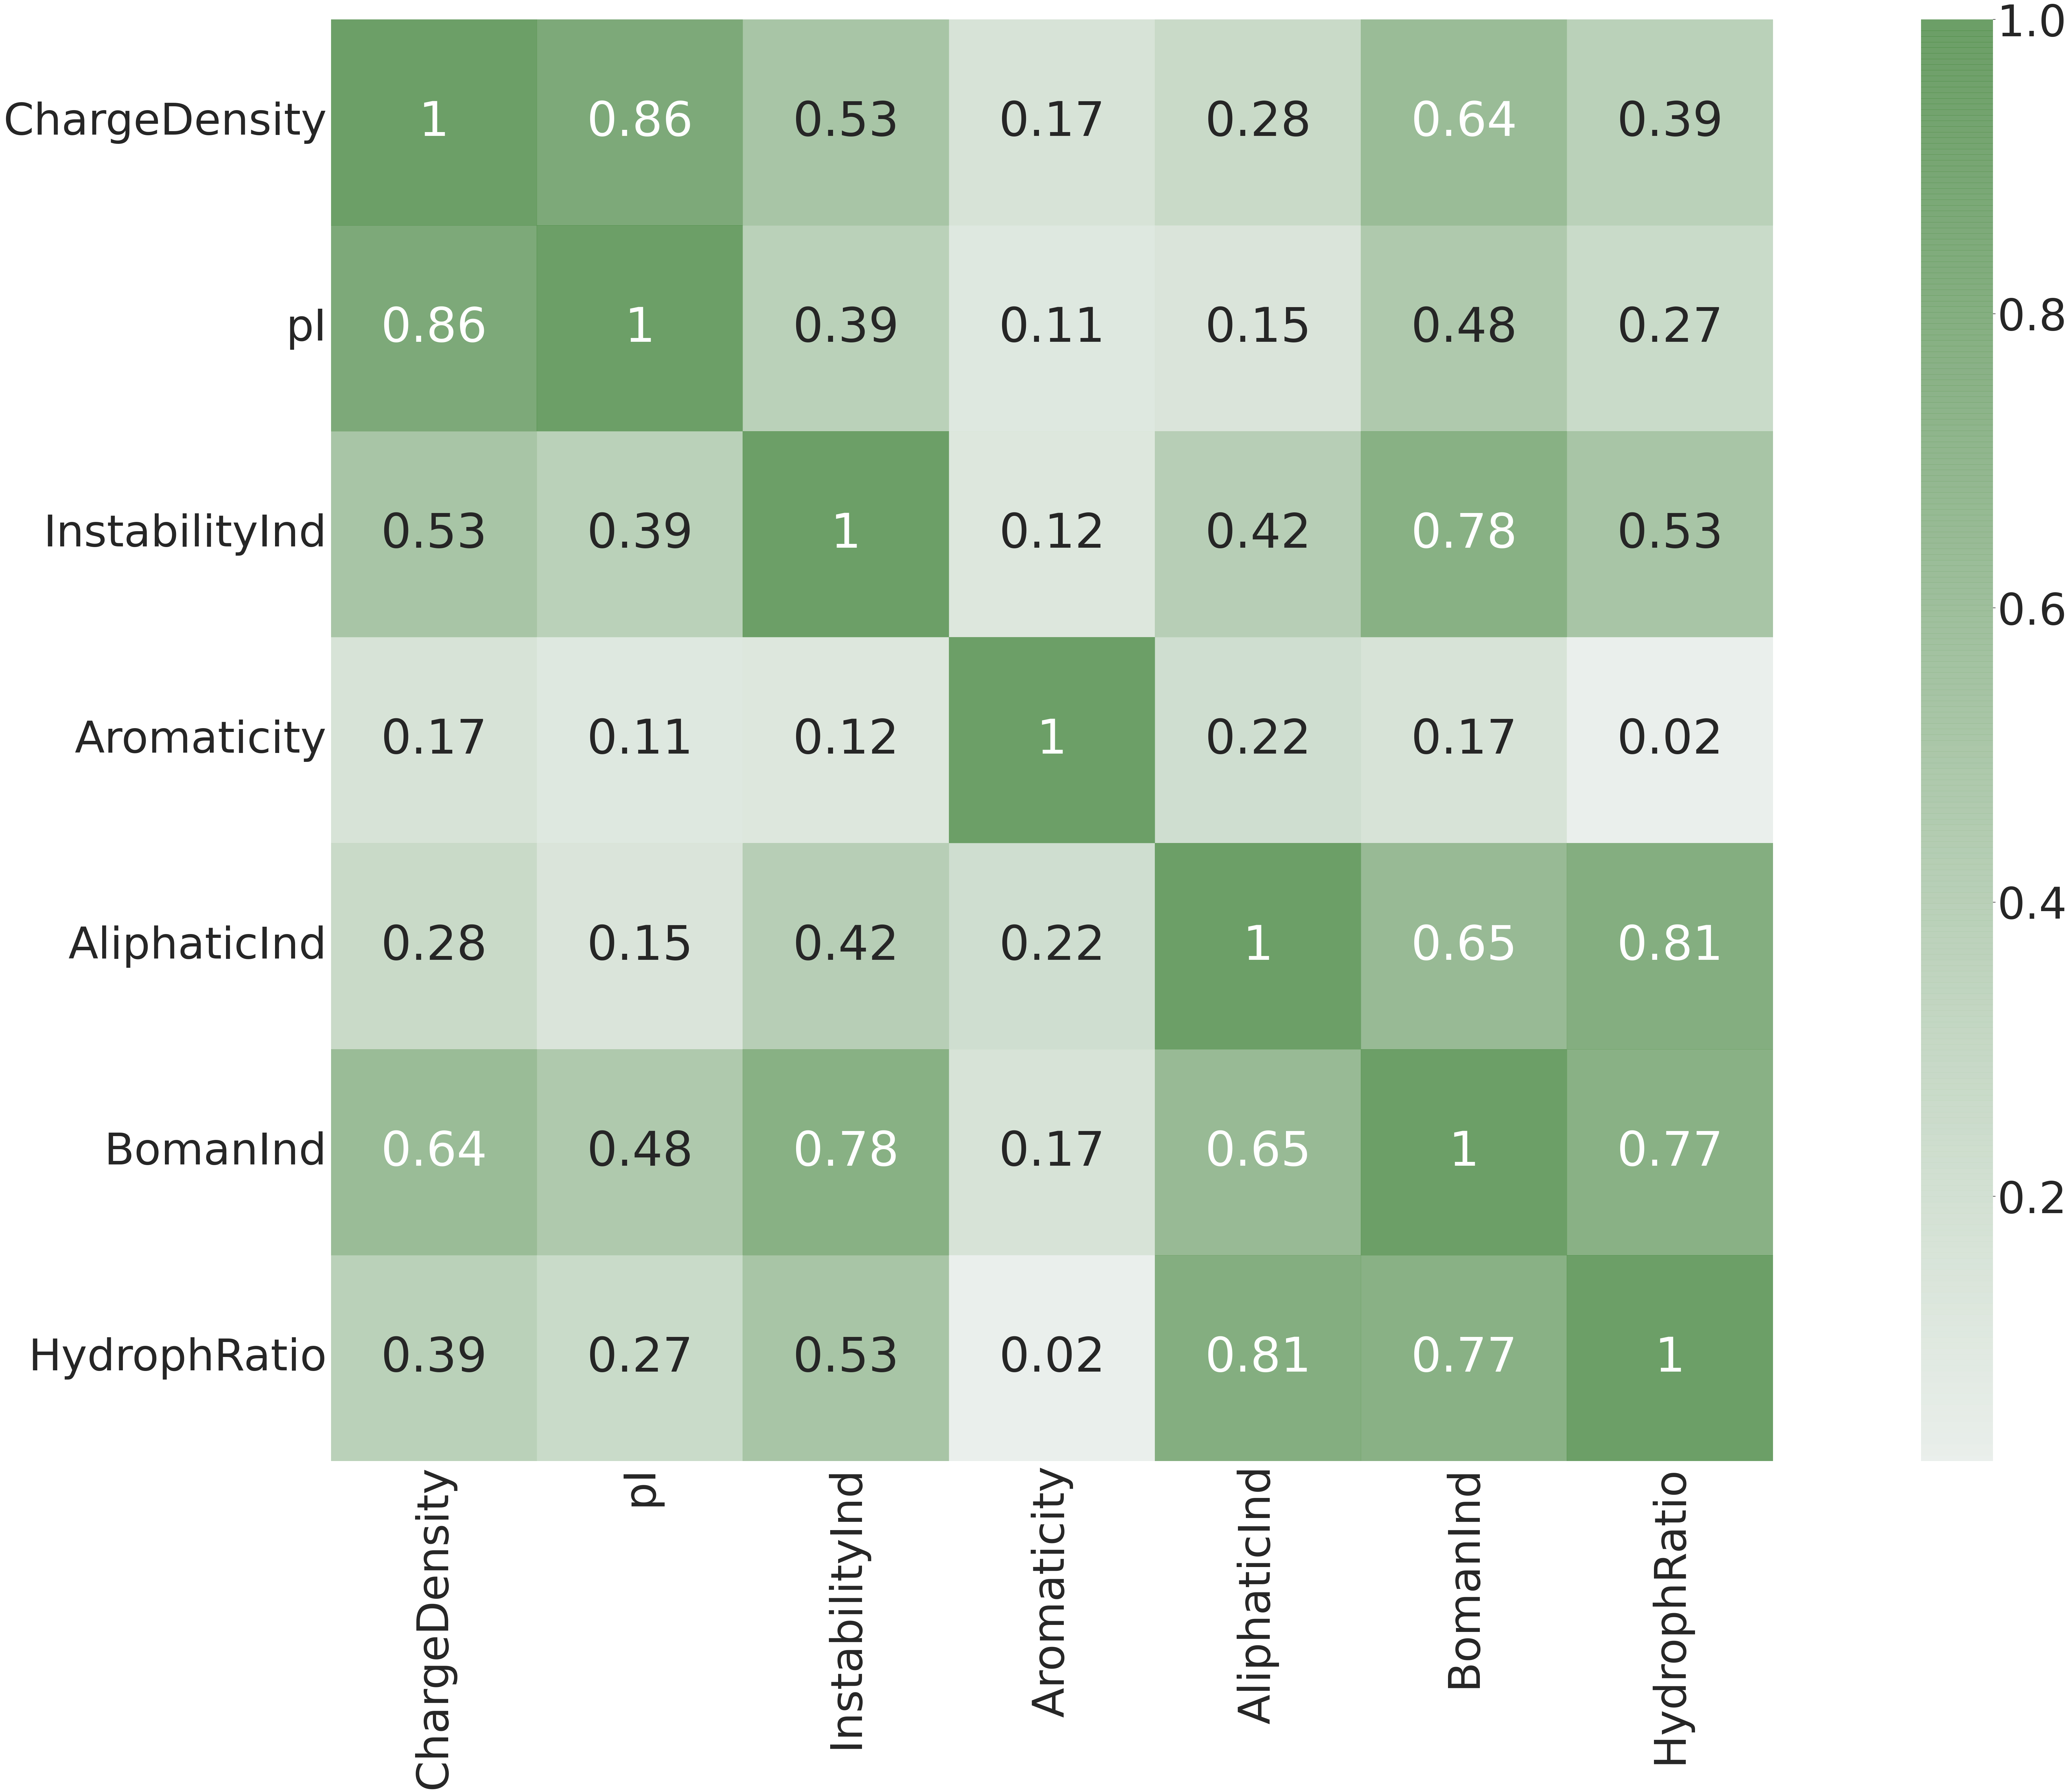

In [ ]:
flag_for_annot = list()
for n in all_descriptors:
    flag_for_annot.append(len(n.columns) < 50)
font_scale = [2.5,3,0,0,0,0,0,0,9]
for name, desc, flag, font in zip(all_descriptors_names, all_descriptors, flag_for_annot, font_scale):
    if flag:
        sns.set(font_scale=font)
        print('Тепловая карта для группы дескрипторов', name)
        create_a_corr_table(desc, flag)

## Удаление высокоскоррелированных дескрипторов

In [ ]:
all_descriptors = [APAAC, PAAC, QSO, SOCN, CTD, GEAR, MORAN, MB, modl_AMP]
df_DESC_not_corr = all_descriptors[0]
for df in all_descriptors[1:]:
    df_DESC_not_corr = pd.concat([df_DESC_not_corr, df], axis = 1)
df_DESC = corr_descriptors(df_DESC_not_corr, 0.9)
df_SAMPLE = pd.concat([df_SAMPLE, df_DESC], axis = 1)

In [ ]:
df_SAMPLE.to_csv(Total_sample_path + 'df_SAMPLE.csv', index = False)
df_DESC.to_csv(Total_sample_path + 'df_DESC.csv', index = False)